In [1]:
import torch, torchvision
import os
import random
import logging #Se renseigner, par encore utilisé
import dataset
import metrics
import time

import constants as cst
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

import loss_fn_v2 as loss_fn
from unet import UNET

In [2]:
random.seed(cst.SEED)
torch.manual_seed(cst.SEED)
np.random.seed(cst.SEED)

def predict_img(model, image, device, transform, out_threshold=0.5):
    with torch.no_grad():
        x = image
        logits = model(x.to(device))
        logits = transform(logits)
        y_pred = nn.Softmax(dim=1)(logits)
        proba = y_pred.detach().cpu().squeeze(0).numpy()[1, :, :]
        return proba > out_threshold

/notebooks/br1a
Training set length: 80
Validation set length: 21
Testing set length: 20
Validation loss before training: 0.7872699499130249
--------------------
Term: br1a
Fold: 0
Ellapsed time: 16.0 minutes 21.454307794570923 secondes
Last val: 0.021071260484556358
Best val: 0.021071260484556358
--------------------


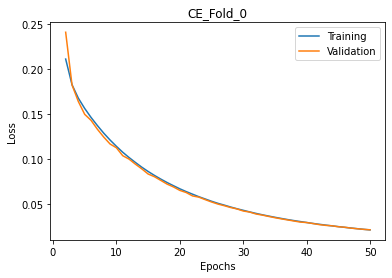

Training set length: 81
Validation set length: 20
Testing set length: 20
Validation loss before training: 0.6366960883140564
--------------------
Term: br1a
Fold: 1
Ellapsed time: 16.0 minutes 53.44777822494507 secondes
Last val: 0.011113057844340801
Best val: 0.011113057844340801
--------------------


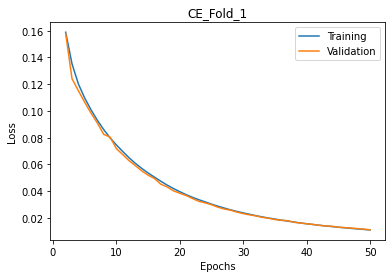

Training set length: 81
Validation set length: 20
Testing set length: 20
Validation loss before training: 0.7157601475715637
--------------------
Term: br1a
Fold: 2
Ellapsed time: 17.0 minutes 26.108118534088135 secondes
Last val: 0.012726798094809056
Best val: 0.012726798094809056
--------------------
Training set length: 81
Validation set length: 20
Testing set length: 20
Validation loss before training: 0.6384669184684754
--------------------
Term: br1a
Fold: 3
Ellapsed time: 17.0 minutes 52.52611827850342 secondes
Last val: 0.014066744223237037
Best val: 0.014066744223237037
--------------------
Training set length: 81
Validation set length: 20
Testing set length: 20
Validation loss before training: 0.7012325406074524
--------------------
Term: br1a
Fold: 4
Ellapsed time: 16.0 minutes 52.29936861991882 secondes
Last val: 0.015046773850917817
Best val: 0.015046773850917817
--------------------
-------------------------
-----------END-----------
-------------------------
Term: br1a
E

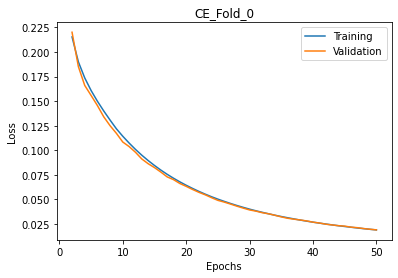

Training set length: 81
Validation set length: 20
Testing set length: 20
Validation loss before training: 0.7497353315353393
--------------------
Term: br1b
Fold: 1
Ellapsed time: 16.0 minutes 29.95282220840454 secondes
Last val: 0.015313977561891078
Best val: 0.015313977561891078
--------------------


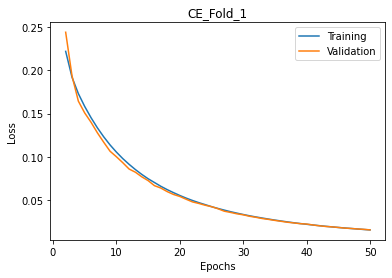

Training set length: 81
Validation set length: 20
Testing set length: 20
Validation loss before training: 0.7621773242950439
--------------------
Term: br1b
Fold: 2
Ellapsed time: 17.0 minutes 22.103598594665527 secondes
Last val: 0.019589468464255334
Best val: 0.019589468464255334
--------------------
Training set length: 81
Validation set length: 20
Testing set length: 20
Validation loss before training: 0.8078409194946289
--------------------
Term: br1b
Fold: 3
Ellapsed time: 17.0 minutes 17.18495464324951 secondes
Last val: 0.013071454130113125
Best val: 0.013071454130113125
--------------------


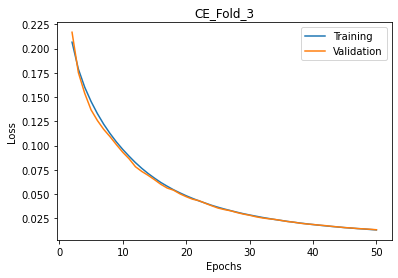

Training set length: 81
Validation set length: 20
Testing set length: 20
Validation loss before training: 0.7185932993888855
--------------------
Term: br1b
Fold: 4
Ellapsed time: 16.0 minutes 39.04572248458862 secondes
Last val: 0.016110932826995848
Best val: 0.016110932826995848
--------------------
-------------------------
-----------END-----------
-------------------------
Term: br1b
Ellapsed time: 84.0 minutes 15.858423233032227 secondes
Best fold: 4
Best validation loss: 0.013071454130113125
Best epoch: 50
Mean val of folds: 0.016630023879309497
Best vals for each fold:
Fold :1 - Val: 0.01906428641329209
Fold :2 - Val: 0.015313977561891078
Fold :3 - Val: 0.019589468464255334
Fold :4 - Val: 0.013071454130113125
Fold :5 - Val: 0.016110932826995848
Name of the run: br1b_Fold_3
Precision: 0.9080323570928008
90% CI: [0.711846 1.      ]
Min, max: 0.5427710843340797 0.999999999997088

Recall: 0.5109048774733411
90% CI: [0.19703859 0.68585125]
Min, max: 0.11985846970340588 0.73231827111

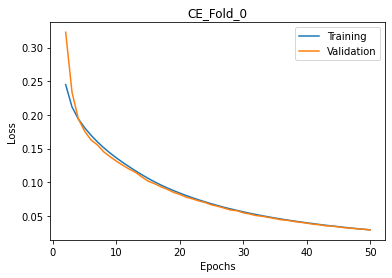

Training set length: 56
Validation set length: 14
Testing set length: 13
Validation loss before training: 0.7429762184619904
--------------------
Term: br2a
Fold: 1
Ellapsed time: 11.0 minutes 51.16385293006897 secondes
Last val: 0.03007733216509223
Best val: 0.03007733216509223
--------------------
Training set length: 56
Validation set length: 14
Testing set length: 13
Validation loss before training: 0.6264145523309708
--------------------
Term: br2a
Fold: 2
Ellapsed time: 12.0 minutes 0.1654186248779297 secondes
Last val: 0.017428178805857897
Best val: 0.017428178805857897
--------------------


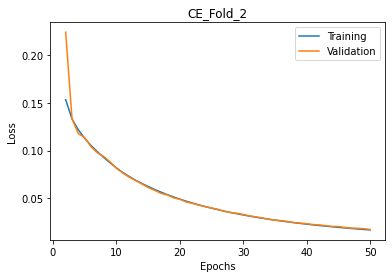

Training set length: 56
Validation set length: 14
Testing set length: 13
Validation loss before training: 0.6797103434801102
--------------------
Term: br2a
Fold: 3
Ellapsed time: 12.0 minutes 6.390842914581299 secondes
Last val: 0.020237682852894068
Best val: 0.020237682852894068
--------------------
Training set length: 56
Validation set length: 14
Testing set length: 13
Validation loss before training: 0.6390046328306198
--------------------
Term: br2a
Fold: 4
Ellapsed time: 12.0 minutes 2.664623260498047 secondes
Last val: 0.02263673208653927
Best val: 0.02263673208653927
--------------------
-------------------------
-----------END-----------
-------------------------
Term: br2a
Ellapsed time: 59.0 minutes 30.301631450653076 secondes
Best fold: 3
Best validation loss: 0.017428178805857897
Best epoch: 50
Mean val of folds: 0.0239185044541955
Best vals for each fold:
Fold :1 - Val: 0.029212596360594034
Fold :2 - Val: 0.03007733216509223
Fold :3 - Val: 0.017428178805857897
Fold :4 - 

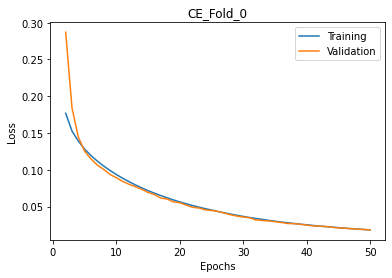

Training set length: 55
Validation set length: 14
Testing set length: 13
Validation loss before training: 0.6643871665000916
--------------------
Term: br2b
Fold: 1
Ellapsed time: 11.0 minutes 46.22435140609741 secondes
Last val: 0.0261183213442564
Best val: 0.0261183213442564
--------------------
Training set length: 55
Validation set length: 14
Testing set length: 13
Validation loss before training: 0.7087967395782471
--------------------
Term: br2b
Fold: 2
Ellapsed time: 12.0 minutes 27.84595489501953 secondes
Last val: 0.015066966414451599
Best val: 0.015066966414451599
--------------------


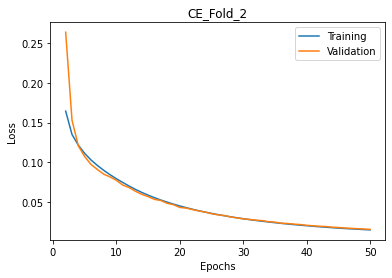

Training set length: 55
Validation set length: 14
Testing set length: 13
Validation loss before training: 0.6982589364051819
--------------------
Term: br2b
Fold: 3
Ellapsed time: 12.0 minutes 24.947763919830322 secondes
Last val: 0.02958978060632944
Best val: 0.02958978060632944
--------------------
Training set length: 56
Validation set length: 13
Testing set length: 13
Validation loss before training: 0.7088475823402405
--------------------
Term: br2b
Fold: 4
Ellapsed time: 11.0 minutes 34.10710835456848 secondes
Last val: 0.018471912015229464
Best val: 0.018471912015229464
--------------------
-------------------------
-----------END-----------
-------------------------
Term: br2b
Ellapsed time: 59.0 minutes 52.45844030380249 secondes
Best fold: 3
Best validation loss: 0.015066966414451599
Best epoch: 50
Mean val of folds: 0.02150541581213474
Best vals for each fold:
Fold :1 - Val: 0.01828009868040681
Fold :2 - Val: 0.0261183213442564
Fold :3 - Val: 0.015066966414451599
Fold :4 - V

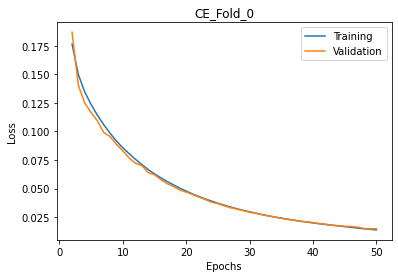

Training set length: 80
Validation set length: 20
Testing set length: 19
Validation loss before training: 0.7110093116760254
--------------------
Term: cb1
Fold: 1
Ellapsed time: 17.0 minutes 4.9797234535217285 secondes
Last val: 0.010401629284024239
Best val: 0.010401629284024239
--------------------


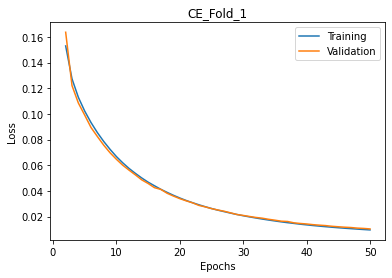

Training set length: 80
Validation set length: 20
Testing set length: 19
Validation loss before training: 0.7250333547592163
--------------------
Term: cb1
Fold: 2
Ellapsed time: 16.0 minutes 38.478222370147705 secondes
Last val: 0.009772428311407566
Best val: 0.009772428311407566
--------------------


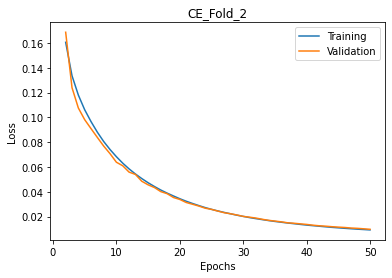

Training set length: 80
Validation set length: 20
Testing set length: 19
Validation loss before training: 0.7711981177330017


In [ ]:
TERMS = ["br1a",
         "br1b",
         "br2a",
         "br2b",
         "cb1"]

for TERM in TERMS:
    start_term = time.time()

    DATASET = "/notebooks/images"
    MASKS = "/notebooks/" + TERM
    
    print(MASKS)

    SIZE = (384, 512)

    DEVICE_NAME = "cpu"
    if torch.cuda.is_available():
        DEVICE_NAME = 'cuda:0'
    DEVICE = torch.device(DEVICE_NAME)

    transform = transforms.Compose([transforms.Resize(SIZE),
                                    transforms.Pad((0, 64, 0, 64))])
    untransform = transforms.Compose([transforms.CenterCrop(SIZE),
                                     transforms.Resize((1932, 2576))])

    model = UNET(3, 2)
    overall_best_model = UNET(3, 2)
    overall_best_model = model
    model.to(DEVICE)

    best_fold = 0
    overall_best = 10
    best_fold_epoch = 0
    fold_best_vals = []

    image_folder = DATASET
    mask_folder = MASKS


    for fold in range(cst.FOLDS):
        start_fold = time.time()
        # Datasets and loaders
        training_set = dataset.ZebrafishDataset_KFold_v2(image_folder,
                                                      mask_folder,
                                                      actual_fold=fold,
                                                      dataset="train",
                                                      folds=5)
        validation_set = dataset.ZebrafishDataset_KFold_v2(image_folder,
                                                        mask_folder,
                                                        actual_fold=fold,
                                                        dataset="validate",
                                                        folds=5)
        testing_set = dataset.ZebrafishDataset_KFold_v2(image_folder,
                                                     mask_folder,
                                                     actual_fold=fold,
                                                     dataset="test",
                                                     folds=5)

        training_loader = torch.utils.data.DataLoader(training_set,
                                                      batch_size=cst.BATCH_SIZE,
                                                      shuffle=True,
                                                      num_workers=cst.WORKERS)

        validation_loader = torch.utils.data.DataLoader(validation_set,
                                                        batch_size=cst.BATCH_SIZE,
                                                        shuffle=True,
                                                        num_workers=cst.WORKERS)

        testing_loader = torch.utils.data.DataLoader(testing_set,
                                                     batch_size=1,
                                                     shuffle=True,
                                                     num_workers=cst.WORKERS)

        # (Channels x Classes)
        model = UNET(3, 2)
        best_model = UNET(3, 2)
        best_model = model
        model.to(DEVICE)

        criterion = nn.CrossEntropyLoss()
        criterion_string = "CE"

        if cst.LOSS == "Dice":
            print("Dice")
            criterion = loss_fn.DiceLoss()
            criterion_string = "DCE"
        if cst.LOSS == "IOU":
            print("IOU")
            criterion = loss_fn.IoULoss()
            criterion_string = "IOU"
        if cst.LOSS == "Tversky":
            print("Tversky")
            criterion = loss_fn.TverskyLoss(alpha=0.7, beta= 0.3)
            criterion_string = "Tversky"

        optimiser = torch.optim.Adam(model.parameters(), lr=cst.LEARNING_RATE, weight_decay=cst.WEIGHT_DECAY)
        optimiser_string = "ADAM" + "_" + "LR" + str(cst.LEARNING_RATE) + "_" + "WD" + str(cst.WEIGHT_DECAY)

        if cst.OPTIMIZER == "SGD":
            optimizer = torch.optim.SGD(model.parameters(),
                                        lr=cst.LEARNING_RATE,
                                        momentum=cst.MOMENTUM,
                                        weight_decay=cst.WEIGHT_DECAY)
            optimiser_string = "SGD" + "_" + "LR" + str(cst.LEARNING_RATE) + "_" + "M" + str(cst.MOMENTUM)
            optimiser_string += "_" + "WD" + str(cst.WEIGHT_DECAY)

        model.eval()
        with torch.no_grad():
            val_loss = []
            for images, masks, names in validation_loader:
                images = transform(images)
                outputs = model(images.to(DEVICE))
                outputs = untransform(outputs)

                masks = masks.type(torch.LongTensor)
                masks = torch.squeeze(masks, 1)

                if cst.LOSS == "CE":
                    vloss = criterion(outputs, masks.to(DEVICE))
                else:
                    #vloss = criterion(outputs, F.one_hot(masks.to(DEVICE), 2).permute(0, 3, 1, 2).float())
                    vloss = criterion(outputs, masks.to(DEVICE))

                loss = vloss.detach().item()
                val_loss.append(loss)

            loss = np.mean(val_loss)
            print("Validation loss before training: {}".format(loss))

        best_val = loss
        best_epoch = 0

        params_string = "Params" + "_" + "Epoch" + str(cst.EPOCHS) + "_" + "BS" + str(cst.BATCH_SIZE)
        params_string += "_" + "W" + str(cst.WORKERS)

        epochs_train_losses = []
        epochs_val_losses = []
        for i in range(cst.EPOCHS):
            #print("Starting epoch {}".format(i+1), end=". ")

            model.train()
            train_loss = []
            for images, masks, names in training_loader:
                images = transform(images)
                outputs = model(images.to(DEVICE))
                outputs = untransform(outputs)

                masks = masks.type(torch.LongTensor)
                #print(masks.shape)
                masks = torch.squeeze(masks, 1)

                if cst.LOSS == "CE":
                    tloss = criterion(outputs, masks.to(DEVICE))
                else:
                    tloss = criterion(outputs, masks.to(DEVICE))
                    #tloss = criterion(outputs, F.one_hot(masks.to(DEVICE), 2).permute(0, 3, 1, 2).float())

                loss = tloss.detach().item()
                train_loss.append(loss)

                optimiser.zero_grad()
                tloss.backward()
                optimiser.step()

            loss = np.mean(train_loss)
            epochs_train_losses.append(loss)
            #print("Trained: {}".format(loss), end=". ")

            model.eval()
            with torch.no_grad():
                val_loss = []
                for images, masks, names in validation_loader:
                    images = transform(images)
                    outputs = model(images.to(DEVICE))
                    outputs = untransform(outputs)

                    masks = masks.type(torch.LongTensor)
                    masks = torch.squeeze(masks, 1)

                    if cst.LOSS == "CE":
                        vloss = criterion(outputs, masks.to(DEVICE))
                    else:
                        #vloss = criterion(outputs, F.one_hot(masks.to(DEVICE), 2).permute(0, 3, 1, 2).float())
                        vloss = criterion(outputs, masks.to(DEVICE))

                    loss = vloss.detach().item()
                    val_loss.append(loss)

                loss = np.mean(val_loss)
                epochs_val_losses.append(loss)
                #print("Validation: {}.".format(loss))

                if loss < best_val:
                    best_val = loss
                    best_model = model
                    best_epoch = i+1

        #print("Training: {}".format(epochs_train_losses))
        #print("Validating: {}".format(epochs_val_losses))
        #print("Best score: {}".format(best_val))

        #model_filepath = os.path.join(cst.MODEL, model_name)
        #best_filepath = os.path.join(cst.MODEL, best_name)
        #torch.save(model.state_dict(), model_filepath)
        #torch.save(best_model.state_dict(), best_filepath)

        fold_best_vals.append(best_val)

        if best_val < overall_best:
            overall_best = best_val
            overall_best_model = best_model
            best_fold_epoch = best_epoch
            best_fold = fold
            
        curr = time.time()
        curr = curr - start_fold
        secondes = curr % 60
        minutes = (curr-secondes)/60

        print("--------------------")
        print("Term: " + TERM)
        print("Fold: {}".format(fold))
        print("Ellapsed time: " + str(minutes) + " minutes " + str(secondes) + " secondes")
        print("Last val: {}".format(loss))
        print("Best val: {}".format(best_val))
        print("--------------------")
        
        


        if fold == best_fold:
            index = [i+1 for i in range(cst.EPOCHS)]
            plt.plot(index[1:], epochs_train_losses[1:], label="Training")
            plt.plot(index[1:], epochs_val_losses[1:], label="Validation")
            plt.title(str(cst.LOSS) + "_Fold_" + str(fold)) 
            plt.ylabel("Loss")
            plt.xlabel("Epochs")
            plt.legend()
            plt.show()
            #plot_name = name + ".png"
            #plt.savefig(plot_name)
        
    # Indent back


    name = TERM + "_Fold" + str(best_fold) +  "_EPOCH" + str(best_fold_epoch) + "_Val" + str(best_val)
    name = name + criterion_string + "_" + optimiser_string + "_" + params_string
    model_name = name + ".pth"
    best_filepath = os.path.join(cst.MODEL, model_name)
    #torch.save(overall_best_model.state_dict(), best_filepath)

    curr = time.time()
    curr = curr - start_term
    secondes = curr % 60
    minutes = (curr-secondes)/60

    print("-------------------------")
    print("-----------END-----------")
    print("-------------------------")
    print("Term: " + TERM)
    print("Ellapsed time: " + str(minutes) + " minutes " + str(secondes) + " secondes")
    print("Best fold: {}".format(best_fold+1))
    print("Best validation loss: {}".format(overall_best))
    print("Best epoch: {}".format(best_fold_epoch))
    print("Mean val of folds: {}".format(np.mean(fold_best_vals)))
    print("Best vals for each fold:")
    a = 0
    for item in fold_best_vals:
        print("Fold :{}".format(a+1), end=" - ")
        print("Val: {}".format(item))
        a=a+1


    tps = 0
    precisions = []
    recalls = []
    F1s = []
    IOUs = []

    eval_model = UNET(3, 2)
    eval_model = overall_best_model

    eval_model.eval()
    for image, mask, name in testing_loader:
        image_name = name[0]
        prediction = predict_img(model, transform(image), DEVICE, untransform, out_threshold=cst.THRESHOLD)
        pred = torch.from_numpy(prediction)

        precisions.append(metrics.precision(pred, mask))
        recalls.append(metrics.recall(pred, mask))
        F1s.append(metrics.F1Score(pred, mask))
        IOUs.append(metrics.IOUScore(pred, mask))

    confidence = 0.9
    print("Name of the run: {}".format(TERM + "_" + "Fold_" + str(best_fold)))
    print("Precision: {}".format(np.mean(precisions)))
    print("90% CI: {}".format(np.percentile(precisions, [100*(1-confidence)/2,100*(1-(1-confidence)/2)])))
    print("Min, max:", np.min(precisions), np.max(precisions))
    print()

    print("Recall: {}".format(np.mean(recalls)))
    print("90% CI: {}".format(np.percentile(recalls, [100*(1-confidence)/2,100*(1-(1-confidence)/2)])))
    print("Min, max:", np.min(recalls), np.max(recalls))
    print()

    print("F1/Dice score: {}".format(np.mean(F1s)))
    print("90% CI: {}".format(np.percentile(F1s, [100*(1-confidence)/2,100*(1-(1-confidence)/2)])))
    print("Min, max:", np.min(F1s), np.max(F1s))
    print()

    print("IoU: {}".format(np.mean(IOUs)))
    print("90% CI: {}".format(np.percentile(IOUs, [100*(1-confidence)/2,100*(1-(1-confidence)/2)])))
    print("Min, max:", np.min(IOUs), np.max(IOUs))
    print()